In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
df = pd.read_csv('./interaction_graph_datasets/TF_data/ISSAAC/ENCFF099QNE.bed', sep='\t', header=None, comment='#', compression='infer')
df = df.sort_values(([0,1]), kind='mergesort').reset_index(drop=True)
# 0:chr, 1:start, 2:end, 9:name, 6:score
tf_bed = df[[0, 1, 2, 9, 6]].copy()
tf_bed.columns = ['chr', 'start', 'end', 'name', 'score']
tf_bed

,chr,start,end,name,score
0,chr1,3448146,3448522,188,91.55344
1,chr1,3611236,3611612,188,79.76813
2,chr1,3841446,3841623,80,134.00604
3,chr1,4058516,4058892,188,73.65352
4,chr1,4142571,4142886,157,411.74714
...,...,...,...,...,...
50822,chrX,169996971,169997347,188,80.72616
50823,chrX,170011101,170011260,79,162.84273
50824,chrX,170019089,170019278,118,140.55137
50825,chrX,170019909,170020480,237,637.70142


In [2]:
atac_anndata = sc.read_h5ad('./interaction_graph_datasets/ISSAAC-seq/ISSAAC_scATAC_format.h5ad')
traditional_chroms = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']
scatac_bed = atac_anndata.var[
    atac_anndata.var['chrom'].isin(traditional_chroms)
][['chrom', 'chromStart', 'chromEnd']].copy()
scatac_bed = scatac_bed.rename(columns={'chrom': 'chr', 'chromStart': 'start', 'chromEnd': 'end'})
scatac_bed = pd.DataFrame(scatac_bed)
scatac_bed['peak'] = scatac_bed.index
print(scatac_bed)

         chr     start       end    peak
0       chr1   3094744   3095664       0
1       chr1   3119738   3120157       1
2       chr1   3120244   3120621       2
3       chr1   3121259   3121993       3
4       chr1   3180886   3181804       4
...      ...       ...       ...     ...
169143  chrY  90803028  90803860  169143
169144  chrY  90804581  90805497  169144
169145  chrY  90807265  90807966  169145
169146  chrY  90808427  90809223  169146
169147  chrY  90813367  90814157  169147

[169148 rows x 4 columns]


In [3]:
import pyranges as pr
scatac_bed = scatac_bed.rename(columns={'chr': 'Chromosome', 'start': 'Start', 'end': 'End'})
tf_bed = tf_bed.rename(columns={'chr': 'Chromosome', 'start': 'Start', 'end': 'End', 'name': 'tf_name', 'score': 'Score'})
scatac_pr = pr.PyRanges(scatac_bed)
tf_pr = pr.PyRanges(tf_bed)
# Compute the peak intersection
intersected_pr = scatac_pr.join(tf_pr, how="left")
df_intersected = intersected_pr.df
print(df_intersected.columns)
columns_a = ['chr', 'start_a', 'end_a', 'peak']  # scATAC 的列
columns_b = ['start_b', 'end_b', 'tf_name', 'score']  # TF 的列
df_intersected = df_intersected.rename(columns={
    'Chromosome': 'chr',
    'Start': 'start_a',
    'End': 'end_a',
    'peak': 'peak',
    'Start_b':'start_b',
    'End_b': 'end_b',
    'tf_name': 'tf_name',
    'Score': 'score'
})
df_intersected = df_intersected[columns_a + columns_b]
df_intersected

Index(['Chromosome', 'Start', 'End', 'peak', 'Start_b', 'End_b', 'tf_name',
       'Score'],
      dtype='object')


,chr,start_a,end_a,peak,start_b,end_b,tf_name,score
0,chr1,3611073,3611804,37,3611236,3611612,188,79.76813
1,chr1,4142199,4143069,59,4142571,4142886,157,411.74714
2,chr1,4227934,4228841,61,4228224,4228487,124,209.19487
3,chr1,4332115,4332977,63,4332508,4332847,170,378.07806
4,chr1,4491683,4492525,66,4492018,4492196,103,127.52445
...,...,...,...,...,...,...,...,...
169839,chrY,90803028,90803860,169143,-1,-1,-1,-1.00000
169840,chrY,90804581,90805497,169144,-1,-1,-1,-1.00000
169841,chrY,90807265,90807966,169145,-1,-1,-1,-1.00000
169842,chrY,90808427,90809223,169146,-1,-1,-1,-1.00000


In [4]:
overlap_scores = {}
for row in df_intersected.itertuples(index=False):
    scatac_peak = row.peak  
    tf_score = float(row.score) 
    if scatac_peak in overlap_scores:
        if tf_score > overlap_scores[scatac_peak]:
            overlap_scores[scatac_peak] = tf_score
    else:
        overlap_scores[scatac_peak] = tf_score
peaks = atac_anndata.var_names.tolist()
scores = [overlap_scores.get(peak, 0.0) for peak in peaks]
print("done")

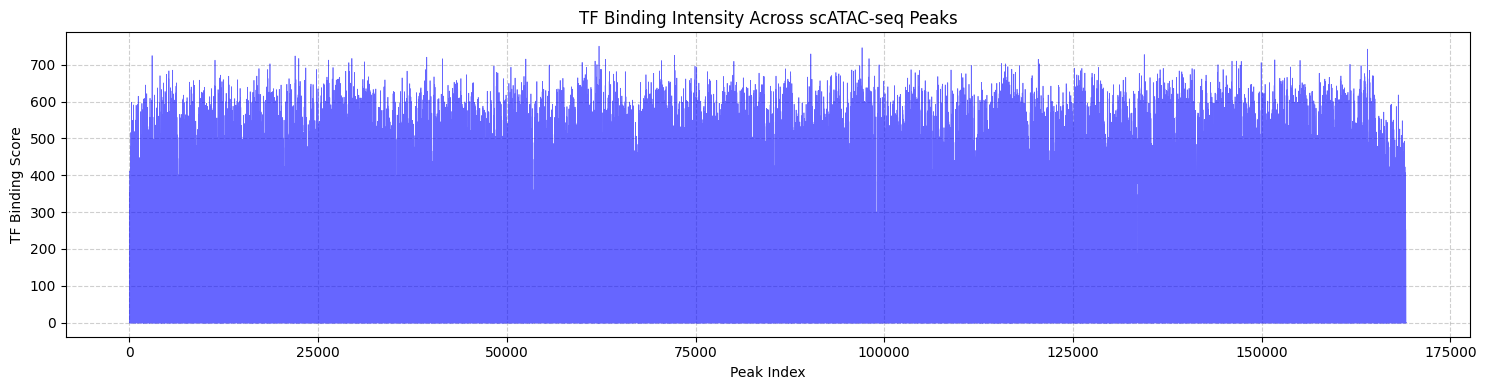

In [5]:
# Print TF-binding-based regulatory maps
plt.figure(figsize=(15, 4))
plt.plot(scores, linewidth=0.5, color='blue', alpha=0.6)
plt.xlabel('Peak Index')
plt.ylabel('TF Binding Score')
plt.title('TF Binding Intensity Across scATAC-seq Peaks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
# Print attention-derived regulatory maps
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
attention_save_dir = "./ISSAAC_test_attention/rna_atac_attention"
file_count = len([f for f in os.listdir(attention_save_dir) if f.endswith(".pt")])
def accumulate_attention_scores(sample_id):
    attention_save_dir = "./ISSAAC_test_attention/rna_atac_attention"
    index_save_dir = "./ISSAAC_test_attention/non_zero_atac_index"
    load_path_attn = os.path.join(attention_save_dir, f"sample_{sample_id}.pt")
    load_path_index = os.path.join(index_save_dir, f"sample_{sample_id}.pt")

    # Loading attention matrix
    if os.path.exists(load_path_attn):
        attention_matrix = torch.load(load_path_attn).squeeze(0)
        if not isinstance(attention_matrix, torch.Tensor):
            attention_matrix = torch.tensor(attention_matrix)
    else:
        print(f"File {load_path_attn} not found!")
        return None

    # Loading non-zero index
    if os.path.exists(load_path_index):
        atac_non_zero_indices = torch.load(load_path_index)
        if not isinstance(atac_non_zero_indices, torch.Tensor):
            atac_non_zero_indices = torch.tensor(atac_non_zero_indices) 
    else:
        print(f"File {load_path_index} not found!")
        return None

    # Accumulate attention scores for each peak
    attention_sum_per_atac = attention_matrix.sum(dim=0).detach().cpu().numpy()
    attention_sum_all_atac = np.zeros(len(scores))
    for idx, non_zero_index in enumerate(atac_non_zero_indices):
        attention_sum_all_atac[non_zero_index] = attention_sum_per_atac[idx]
    return attention_sum_all_atac

attention_sum_all_atac = np.zeros(len(scores))
for id in range(0,file_count):
    attention_sum_all_atac = attention_sum_all_atac + accumulate_attention_scores(id)
print("done")

119


C:\Users\82705\AppData\Local\Temp\ipykernel_50804\2773445655.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_matrix = torch.load(load_path_attn).squeeze(0)
C:

done


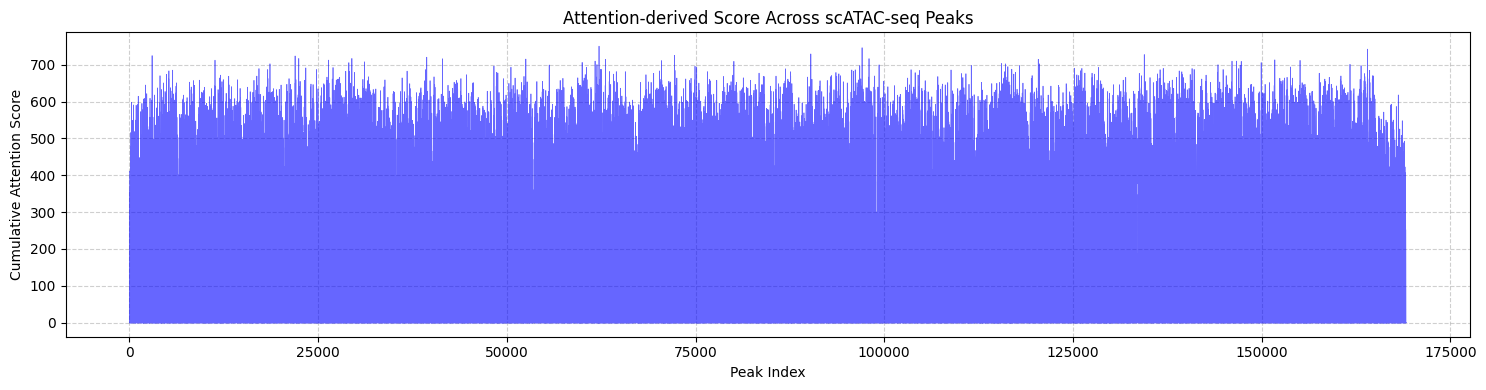

In [11]:
# Print attention-derived regulatory maps
plt.figure(figsize=(15, 4))
plt.plot(scores, linewidth=0.5, color='blue', alpha=0.6)
plt.xlabel('Peak Index')
plt.ylabel('Cumulative Attention Score')
plt.title('Attention-derived Score Across scATAC-seq Peaks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Print correlation metrics
from sklearn.metrics.pairwise import cosine_similarity
score = torch.tensor(scores).numpy() 
# Cosine Similarity
similarity = cosine_similarity(score.reshape(1, -1), attention_sum_all_atac.reshape(1, -1))[0][0]
print("Cosine Similarity:", similarity)
from scipy.stats import pearsonr
# Pearson Correlation
correlation, _ = pearsonr(score, attention_sum_all_atac)
print("Pearson Correlation Coefficient:", correlation)
# Top-10000 Jaccard
top_10000_score_indices = np.argsort(score)[-10000:]  # 选取score中最大的1000个索引
top_10000_atac_indices = np.argsort(attention_sum_all_atac)[-10000:]  # 选取attention_sum_all_atac中最大的1000个索引
print(top_10000_score_indices)
print(top_10000_atac_indices)
set_score = set(top_10000_score_indices)
set_atac = set(top_10000_atac_indices)
intersection = set_score.intersection(set_atac)
union = set_score.union(set_atac)
jaccard_index = len(intersection) / len(union)
print("Jaccard Index:", jaccard_index)

[RESULT] Pearson=0.8061, Cosine=0.3677, Jaccard=0.7001
{'pearson': 0.8061141397770204, 'cosine': 0.36771196893285657, 'jaccard': 0.7001020061203672}


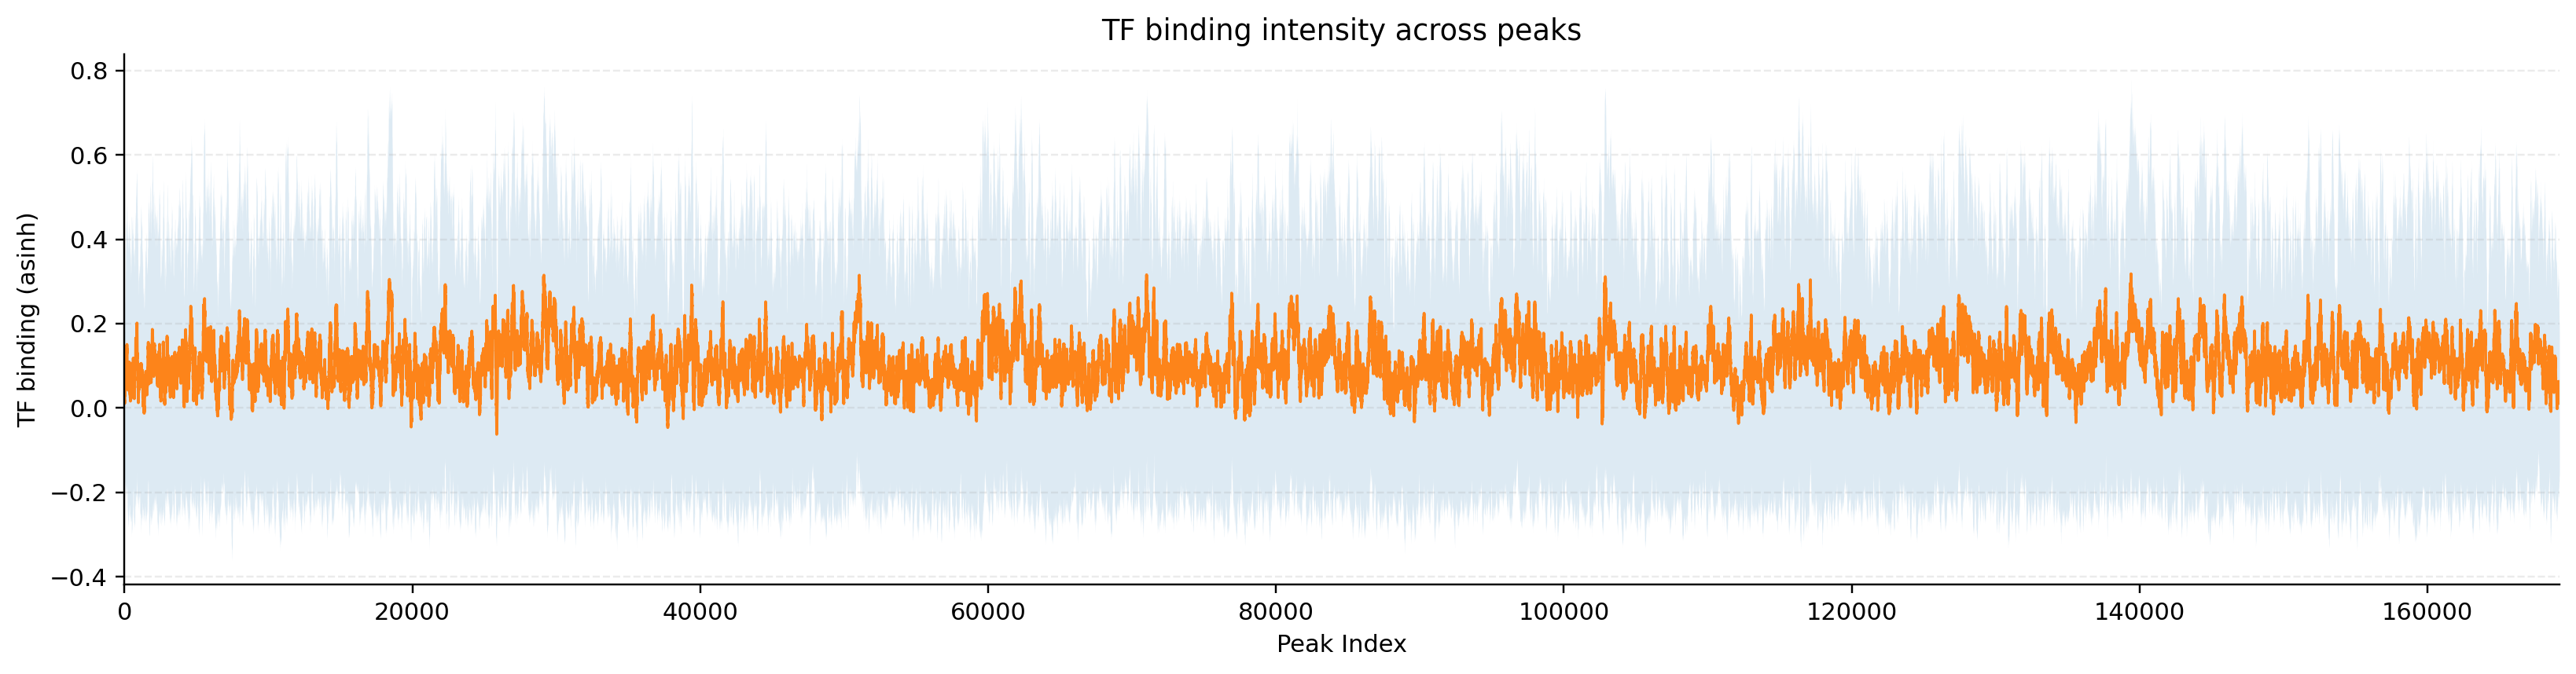

In [34]:
# (Optional) Enhance the image
import numpy as np
import matplotlib.pyplot as plt

y = np.asarray(scores, dtype=float)
N = y.size
scale = np.percentile(y, 95) + 1e-8
yt = np.arcsinh(y / scale)
cap = np.percentile(yt, 99.5)
yt = np.clip(yt, None, cap)
w_frac = 0.00001                   
win = max(101, int(N * w_frac))    
if win % 2 == 0: win += 1          
w = np.ones(win) / win
mu = np.convolve(yt, w, mode="same")
mu2 = np.convolve(yt*yt, w, mode="same")
sigma = np.sqrt(np.clip(mu2 - mu*mu, 0, None))
x = np.arange(N)

plt.figure(figsize=(15, 4), dpi=220)
plt.fill_between(x, mu - sigma, mu + sigma, color='tab:blue', alpha=0.15, lw=0)
plt.plot(x, mu, lw=1.2, color='tab:orange', alpha=0.95)
plt.xlim(0, N-1)
plt.xlabel('Peak Index')
plt.ylabel('TF binding (asinh)')
plt.title('TF binding intensity across peaks')
plt.grid(True, axis='y', linestyle='--', alpha=0.25)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("TF2.png", bbox_inches="tight", dpi=600)
plt.show()